# Baselines

## Extended Kalman Filter

In [1]:
from pathlib import Path
from scipy.spatial.transform import Rotation
import pandas as pd
import os
from os import path as osp
import numpy as np
from kalman_filter import ExtendedKalmanFilter
from metric import compute_ate_rte
import matplotlib.pyplot as plt

In [2]:
def test_kalman_filter(sample_data, gt_noise_std = 2, ori_noise_std = 0.05, std_dev = 0.01):

    time_arr = np.linspace(0, len(sample_data)*0.01, num = len(sample_data))
    
    quaternion = sample_data[['rotation.x', 'rotation.y', 'rotation.z', 'rotation.w',]].values

    # Create a rotation object from the quaternion
    rotation = Rotation.from_quat(quaternion)

    # Convert the quaternion to Euler angles
    euler_orientations = rotation.as_euler('xyz', degrees= False)

    # Convert acceleration into m/s^2
    acc = sample_data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']].values
    acc = acc * 9.81

    gyro = sample_data[['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)']].values

    N = len(sample_data)

    xy_obs_noise = np.random.normal(0.0, gt_noise_std, (N, 2))  # gen gaussian noise
    gt_trajectory_xy = sample_data[['translation.x','translation.y']].values
    obs_trajectory_xy = gt_trajectory_xy.copy()

    print(obs_trajectory_xy.shape)
    obs_trajectory_xy += xy_obs_noise  # add the noise to ground-truth positions
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    xs, ys = gt_trajectory_xy[:, 0], gt_trajectory_xy[:, 1]
    ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

    xs, ys = obs_trajectory_xy[:, 0], obs_trajectory_xy[:, 1]
    ax.plot(xs, ys, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy trajectory')

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.legend()
    ax.grid()

    N = len(sample_data)

    orientation_obs_noise = np.random.normal(0.0, ori_noise_std, (N, 3))  # gen gaussian noise
    gt_orientation = euler_orientations
    obs_orientation = euler_orientations.copy()

    obs_orientation += orientation_obs_noise  # add the noise to ground-truth positions
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    roll, pitch, yaw = gt_orientation[:, 0], gt_orientation[:, 1], gt_orientation[:,2]
    ax.plot(roll, lw=2, label='ground-truth roll')
    ax.plot(pitch, lw=2, label= 'ground truth pitch')
    ax.plot(yaw, lw=2, label= 'ground truth yaw')

    roll, pitch, yaw = obs_orientation[:, 0], obs_orientation[:, 1], obs_orientation[:,2]
    ax.plot(roll, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy roll')
    ax.plot(pitch, lw=0, marker='.', markersize=2, alpha=0.4,label= 'noisy pitch')
    ax.plot(yaw, lw=0, marker='.', markersize=2, alpha=0.4,label= 'noisy yaw')

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.legend()
    ax.grid()

    # initial state x_0
    # State: [x position, y position, roll, pitch, yaw, velocity_x, velocity_y]; Assume velocity start at 0

    initial_list = [obs_trajectory_xy[0, 0], obs_trajectory_xy[0, 1], obs_orientation[0, 0], obs_orientation[0, 1], obs_orientation[0, 2], 0, 0]

    x = np.array(initial_list)

    # P covariance for initial state estimation error

    P = np.array([
        [gt_noise_std ** 2, 0, 0, 0, 0, 0, 0],
        [0, gt_noise_std ** 2, 0, 0, 0, 0, 0],
        [0, 0, ori_noise_std ** 2, 0, 0, 0, 0],
        [0, 0, 0,ori_noise_std ** 2 , 0, 0, 0],
        [0, 0, 0, 0, ori_noise_std ** 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]
    ])

    # R (numpy.array): Measurement noise covariance matrix
    R = np.array([
        [gt_noise_std ** 2, 0, 0, 0, 0],
        [0, gt_noise_std ** 2, 0, 0, 0],
        [0, 0, ori_noise_std ** 2, 0, 0],
        [0, 0, 0,ori_noise_std ** 2 , 0],
        [0, 0, 0, 0, ori_noise_std ** 2]
    ])

    # State transition noise covariance will depend on how noisy is my acceleration and gyroscope data. For now lets assume a normal std of 0.01
    # Q (numpy.array): Process noise covariance matrix
    Q = np.eye(7) * (std_dev ** 2)

    # Initialize Kalman filter
    kf = ExtendedKalmanFilter(x, P)

    # Arrays to store estimated 2D pose [x, y, roll, pitch, yaw]
    mu_x = [x[0]]
    mu_y = [x[1]]
    mu_roll = [x[2]]
    mu_pitch = [x[3]]
    mu_yaw = [x[4]]

    # Arrays to store estimated error variance of 2D pose
    var_x = [P[0, 0]]
    var_y = [P[1, 1]]
    var_roll = [P[2, 2]]
    var_pitch = [P[3, 3]]
    var_yaw = [P[4, 4]]

    t_last = time_arr[0]

    for t_idx in range(1, N):
        t = time_arr[t_idx]
        dt = t - t_last
        
        # Get control input `u = [acceleration_x, acceleration_y, acceleration_z, roll_rate, pitch_rate, yaw_rate]`
        u = np.array([
            acc[t_idx, 0],
            acc[t_idx, 1],
            acc[t_idx, 2],
            gyro[t_idx, 0],
            gyro[t_idx, 1],
            gyro[t_idx, 2]
        ])
        
        # Because the acceleration and angular rates are already in the global frame,
        # we can directly use them in the propagation step
        
        # Propagate!
        kf.propagate(u, dt, Q)
        
        # Get measurement `z = [position_x, position_y, roll, pitch, yaw]`
        z = np.array([
            obs_trajectory_xy[t_idx, 0],
            obs_trajectory_xy[t_idx, 1],
            obs_orientation[t_idx, 0],
            obs_orientation[t_idx, 1],
            obs_orientation[t_idx, 2]
        ])
        
        # Update!
        kf.update(z, R)
        
        # Save estimated state to analyze later
        mu_x.append(kf.x[0])
        mu_y.append(kf.x[1])
        mu_roll.append(kf.x[2])
        mu_pitch.append(kf.x[3])
        mu_yaw.append(kf.x[4])
        
        # Save estimated variance to analyze later
        var_x.append(kf.P[0, 0])
        var_y.append(kf.P[1, 1])
        var_roll.append(kf.P[2, 2])
        var_pitch.append(kf.P[3, 3])
        var_yaw.append(kf.P[4, 4])
        
        t_last = t

    mu_x = np.array(mu_x)
    mu_y = np.array(mu_y)
    mu_roll = np.array(mu_roll)
    mu_pitch = np.array(mu_pitch)
    mu_yaw = np.array(mu_yaw)

    var_x = np.array(var_x)
    var_y = np.array(var_y)
    var_roll = np.array(var_roll)
    var_pitch = np.array(var_pitch)
    var_yaw = np.array(var_yaw)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    xs, ys = gt_trajectory_xy[:, 0], gt_trajectory_xy[:, 1]
    ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

    xs, ys = obs_trajectory_xy[:, 0], obs_trajectory_xy[:, 1]
    ax.plot(xs, ys, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy trajectory')

    ax.plot(mu_x, mu_y, lw=1, label='estimated trajectory', color='r')

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.legend()
    ax.grid()

    pos_pred = np.zeros((N,2))
    pos_pred[:,0] = mu_x
    pos_pred[:,1] = mu_y


    ate, rte = compute_ate_rte(pos_pred, gt_trajectory_xy, 1)
    print('ATE: ', ate)
    print('RTE: ', rte)
    
    return ate, rte


(15500, 2)
ATE:  1.706586015517239
RTE:  0.18487847864514936


(1.706586015517239, 0.18487847864514936)

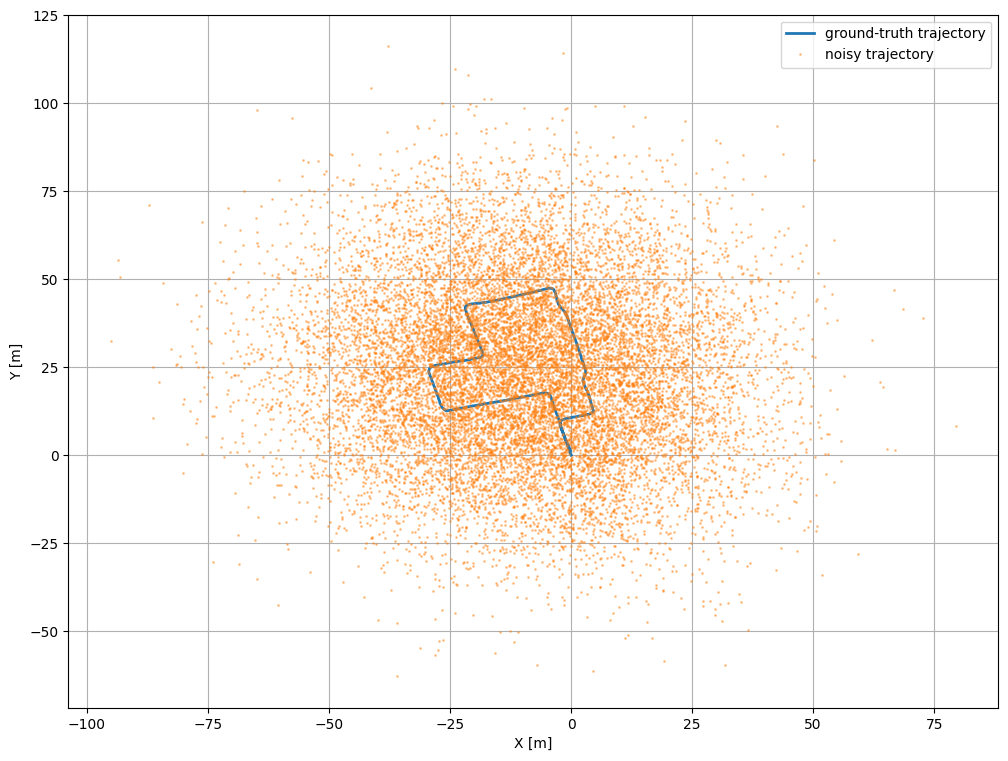

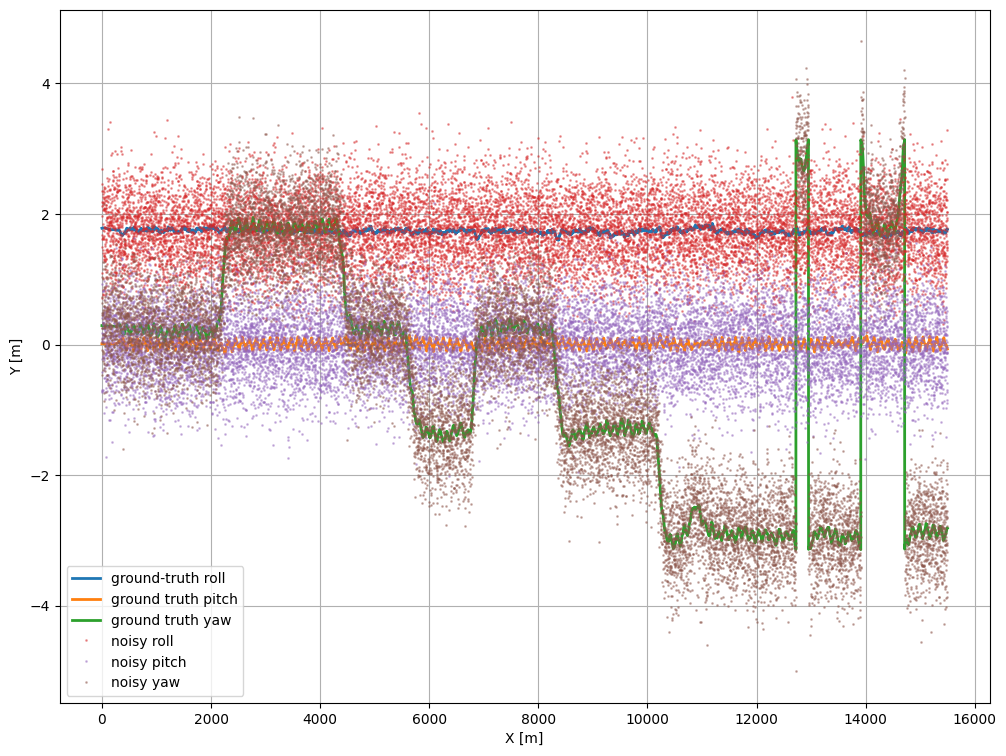

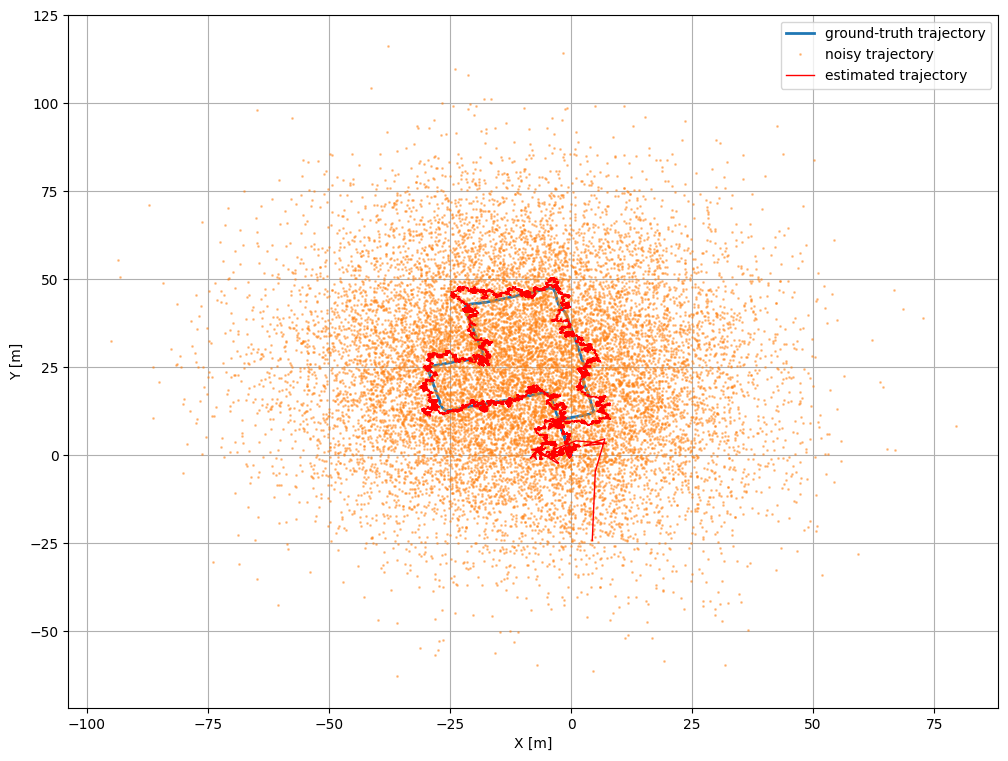

In [8]:
dataset_folder = osp.join(Path(os.getcwd()).parents[2], 'localisation_datasets')
data = pd.read_csv(dataset_folder + '/Oxford Inertial Odometry Dataset/large scale/floor4/combined2.csv')

sample_data = data.iloc[:15500]
#best std_dev = 0.03
test_kalman_filter(sample_data, gt_noise_std = 20, ori_noise_std = 0.5, std_dev = 0.03)

# ate_list = []
# std_dev_list = []


# for i in range(1,40, 1):
#     i = i/200
#     print('std_dev: ', i)
#     ate, rte = test_kalman_filter(sample_data, gt_noise_std = 10, ori_noise_std = 0.05, std_dev = i)
#     ate_list.append(ate)
#     std_dev_list.append(i)

# fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# ax.plot(std_dev_list, ate_list, lw=2, label='ate')


# ax.set_xlabel('std_dev')
# ax.set_ylabel('ate')
# ax.legend()
# ax.grid()

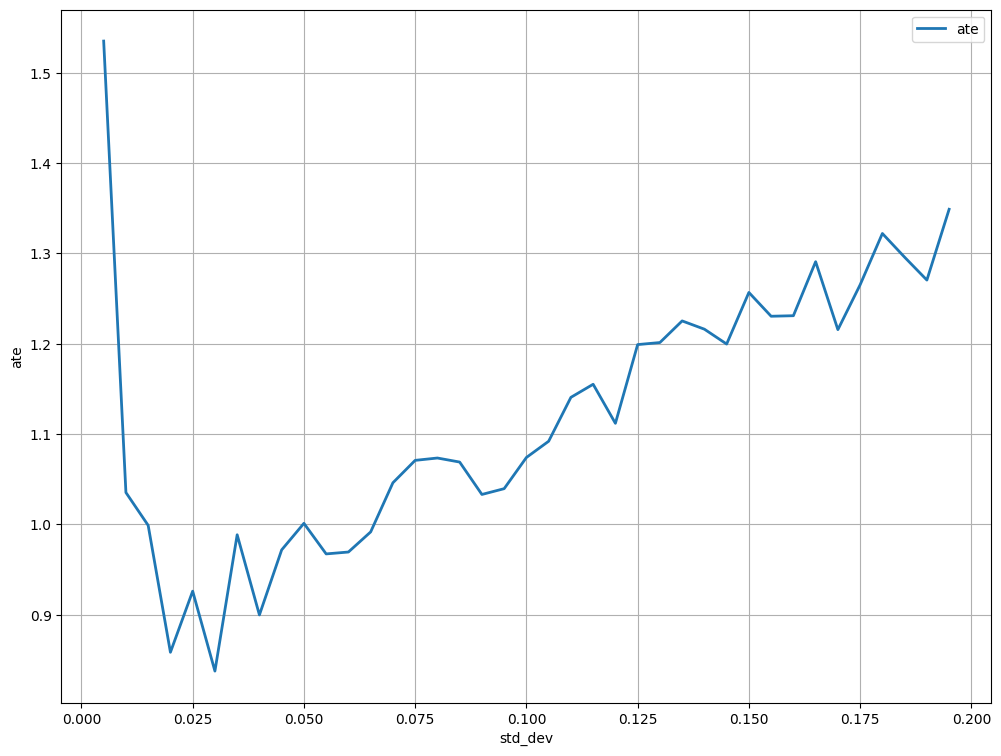

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.plot(std_dev_list, ate_list, lw=2, label='ate')


ax.set_xlabel('std_dev')
ax.set_ylabel('ate')
ax.legend()
ax.grid()

In [69]:
quaternion = sample_data[['rotation.w', 'rotation.x', 'rotation.y', 'rotation.z']].values

# Create a rotation object from the quaternion
rotation = Rotation.from_quat(quaternion)

# Convert the quaternion to Euler angles
euler_orientations = rotation.as_euler('xyz', degrees= False)

# Convert acceleration into m/s^2
acc = sample_data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']].values
acc = acc * 9.81

gyro = sample_data[['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)']].values

### Add noise to ground truth coordinate and orientation data

(16500, 2)


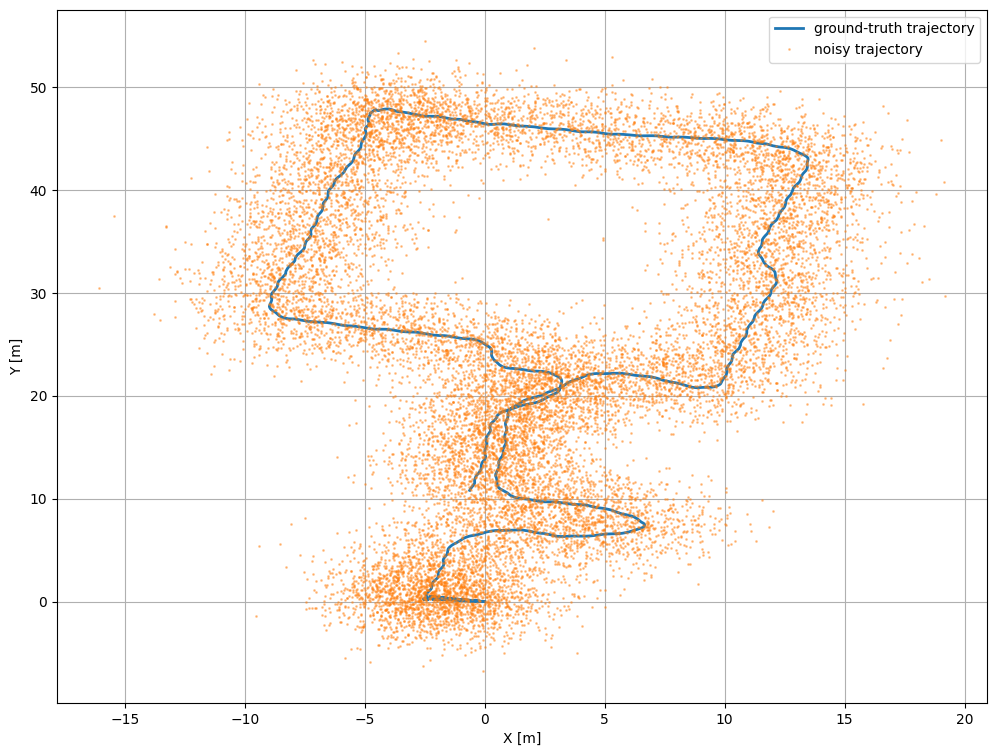

In [70]:
gt_noise_std = 2  # standard deviation of observation noise of x and y in meter
N = len(sample_data)

xy_obs_noise = np.random.normal(0.0, gt_noise_std, (N, 2))  # gen gaussian noise
gt_trajectory_xy = sample_data[['translation.x','translation.y']].values
obs_trajectory_xy = gt_trajectory_xy.copy()

print(obs_trajectory_xy.shape)
obs_trajectory_xy += xy_obs_noise  # add the noise to ground-truth positions
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys = gt_trajectory_xy[:, 0], gt_trajectory_xy[:, 1]
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys = obs_trajectory_xy[:, 0], obs_trajectory_xy[:, 1]
ax.plot(xs, ys, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

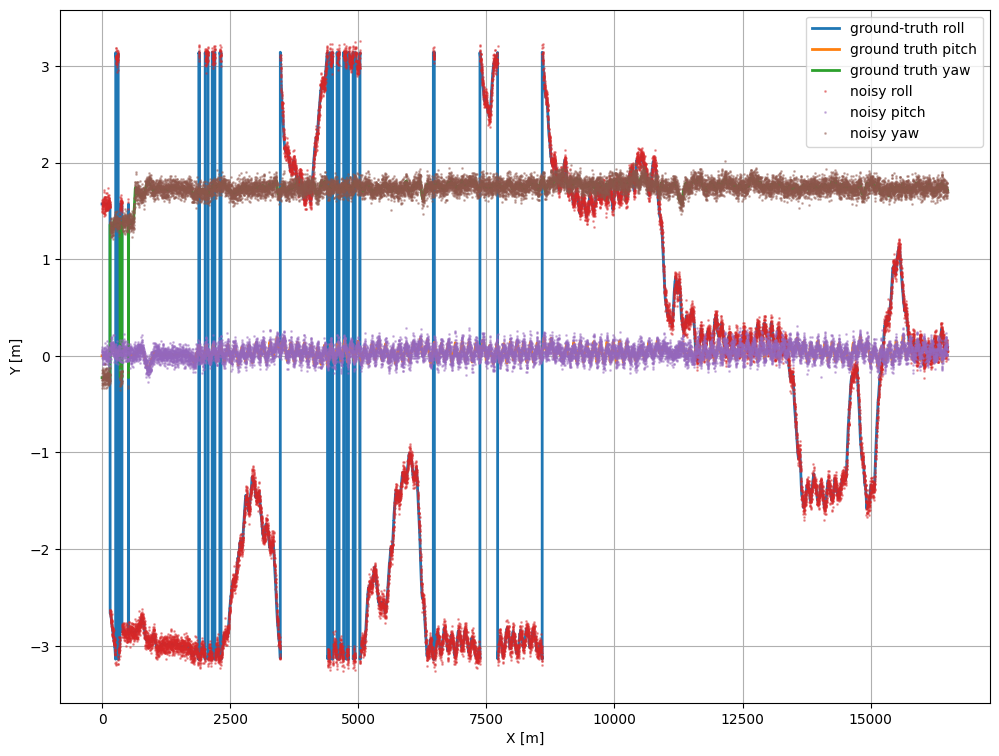

In [71]:
ori_noise_std = 0.05  # standard deviation of observation noise of x and y in meter
N = len(sample_data)

orientation_obs_noise = np.random.normal(0.0, ori_noise_std, (N, 3))  # gen gaussian noise
gt_orientation = euler_orientations
obs_orientation = euler_orientations.copy()

obs_orientation += orientation_obs_noise  # add the noise to ground-truth positions
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

roll, pitch, yaw = gt_orientation[:, 0], gt_orientation[:, 1], gt_orientation[:,2]
ax.plot(roll, lw=2, label='ground-truth roll')
ax.plot(pitch, lw=2, label= 'ground truth pitch')
ax.plot(yaw, lw=2, label= 'ground truth yaw')

roll, pitch, yaw = obs_orientation[:, 0], obs_orientation[:, 1], obs_orientation[:,2]
ax.plot(roll, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy roll')
ax.plot(pitch, lw=0, marker='.', markersize=2, alpha=0.4,label= 'noisy pitch')
ax.plot(yaw, lw=0, marker='.', markersize=2, alpha=0.4,label= 'noisy yaw')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid();

In [72]:
# initial state x_0
# State: [x position, y position, roll, pitch, yaw, velocity_x, velocity_y]; Assume velocity start at 0

initial_list = [obs_trajectory_xy[0, 0], obs_trajectory_xy[0, 1], obs_orientation[0, 0], obs_orientation[0, 1], obs_orientation[0, 2], 0, 0]

x = np.array(initial_list)

# P covariance for initial state estimation error

P = np.array([
    [gt_noise_std ** 2, 0, 0, 0, 0, 0, 0],
    [0, gt_noise_std ** 2, 0, 0, 0, 0, 0],
    [0, 0, ori_noise_std ** 2, 0, 0, 0, 0],
    [0, 0, 0,ori_noise_std ** 2 , 0, 0, 0],
    [0, 0, 0, 0, ori_noise_std ** 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
])

# R (numpy.array): Measurement noise covariance matrix
R = np.array([
    [gt_noise_std ** 2, 0, 0, 0, 0],
    [0, gt_noise_std ** 2, 0, 0, 0],
    [0, 0, ori_noise_std ** 2, 0, 0],
    [0, 0, 0,ori_noise_std ** 2 , 0],
    [0, 0, 0, 0, ori_noise_std ** 2]
])

# State transition noise covariance will depend on how noisy is my acceleration and gyroscope data. For now lets assume a normal std of 0.01
std_dev = 10
# Q (numpy.array): Process noise covariance matrix
Q = np.eye(6) * (std_dev ** 2)

In [73]:
# Initialize Kalman filter
kf = ExtendedKalmanFilter(x, P)

# Arrays to store estimated 2D pose [x, y, roll, pitch, yaw]
mu_x = [x[0]]
mu_y = [x[1]]
mu_roll = [x[2]]
mu_pitch = [x[3]]
mu_yaw = [x[4]]

# Arrays to store estimated error variance of 2D pose
var_x = [P[0, 0]]
var_y = [P[1, 1]]
var_roll = [P[2, 2]]
var_pitch = [P[3, 3]]
var_yaw = [P[4, 4]]

t_last = time_arr[0]

for t_idx in range(1, N):
    t = time_arr[t_idx]
    dt = t - t_last
    
    # Get control input `u = [acceleration_x, acceleration_y, acceleration_z, roll_rate, pitch_rate, yaw_rate]`
    u = np.array([
        acc[t_idx, 0],
        acc[t_idx, 1],
        acc[t_idx, 2],
        gyro[t_idx, 0],
        gyro[t_idx, 1],
        gyro[t_idx, 2]
    ])
    
    # Because the acceleration and angular rates are already in the global frame,
    # we can directly use them in the propagation step
    
    # Propagate!
    kf.propagate(u, dt, Q)
    
    # Get measurement `z = [position_x, position_y, roll, pitch, yaw]`
    z = np.array([
        obs_trajectory_xy[t_idx, 0],
        obs_trajectory_xy[t_idx, 1],
        obs_orientation[t_idx, 0],
        obs_orientation[t_idx, 1],
        obs_orientation[t_idx, 2]
    ])
    
    # Update!
    kf.update(z, R)
    
    # Save estimated state to analyze later
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    mu_roll.append(kf.x[2])
    mu_pitch.append(kf.x[3])
    mu_yaw.append(kf.x[4])
    
    # Save estimated variance to analyze later
    var_x.append(kf.P[0, 0])
    var_y.append(kf.P[1, 1])
    var_roll.append(kf.P[2, 2])
    var_pitch.append(kf.P[3, 3])
    var_yaw.append(kf.P[4, 4])
    
    t_last = t

mu_x = np.array(mu_x)
mu_y = np.array(mu_y)
mu_roll = np.array(mu_roll)
mu_pitch = np.array(mu_pitch)
mu_yaw = np.array(mu_yaw)

var_x = np.array(var_x)
var_y = np.array(var_y)
var_roll = np.array(var_roll)
var_pitch = np.array(var_pitch)
var_yaw = np.array(var_yaw)


### Visualise estimated results

(1.9252916389789554, 2.6765854863550107)

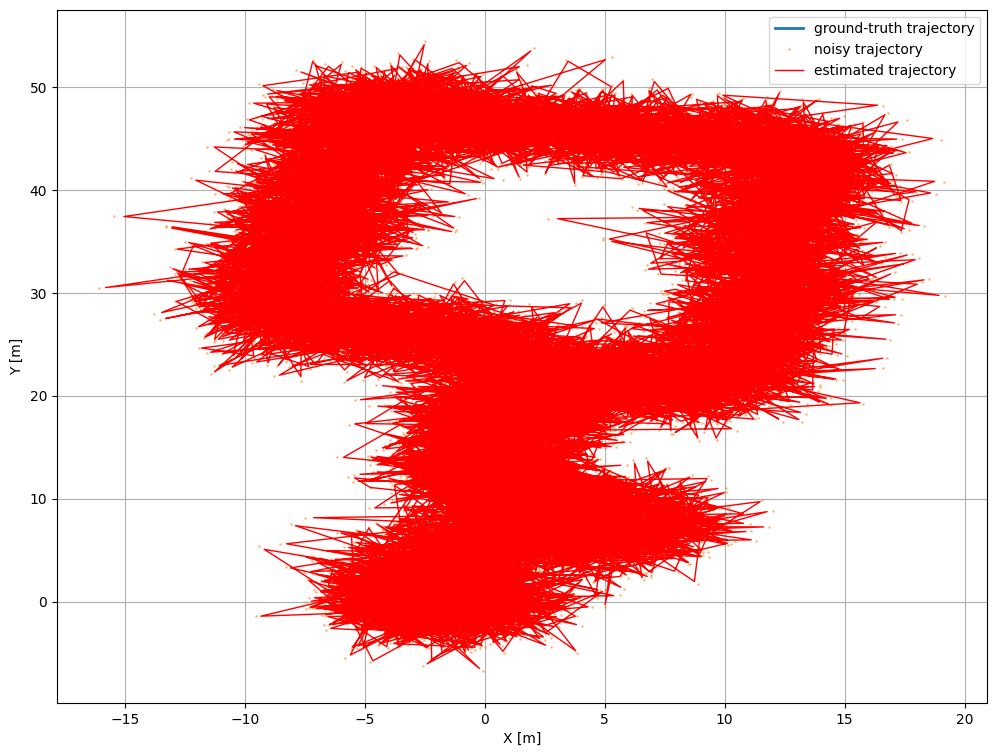

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys = gt_trajectory_xy[:, 0], gt_trajectory_xy[:, 1]
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys = obs_trajectory_xy[:, 0], obs_trajectory_xy[:, 1]
ax.plot(xs, ys, lw=0, marker='.', markersize=2, alpha=0.4, label='noisy trajectory')

ax.plot(mu_x, mu_y, lw=1, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

pos_pred = np.zeros((N,2))
pos_pred[:,0] = mu_x
pos_pred[:,1] = mu_y


compute_ate_rte(pos_pred, gt_trajectory_xy, 1)



In [75]:
! pip install numpy-quaternion

^C
ERROR: Operation cancelled by user


In [ ]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

In [ ]:
def get_dataset(root_dir, data_list):
    
    sequence = OxfordGlobSpeedSequence(osp.join(root_dir, data_list))
    return sequence.features, sequence.targets, sequence.gt_pos


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list)    

In [ ]:
feat, targ, gt_pos = get_dataset('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1', 'combined3.csv')

In [ ]:
import pandas as pd
full_data = pd.read_csv('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1/combined3.csv')

In [ ]:
gravity_data = pd.read_csv('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1/syn/imu1.csv')
imu_column_names = ['Time', 'attitude_roll(radians)', 'attitude_pitch(radians)', 'attitude_yaw(radians)',
                'rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)',
                'gravity_x(G)', 'gravity_y(G)', 'gravity_z(G)', 'user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)',
                'magnetic_field_x(microteslas)', 'magnetic_field_y(microteslas)', 'magnetic_field_z(microteslas)']
gravity_data.columns = imu_column_names
gravity_data = gravity_data[['gravity_x(G)', 'gravity_y(G)', 'gravity_z(G)']]

In [ ]:
import numpy as np

def quaternion_to_rotation_matrix(q):
    # Normalize the quaternion
    q = q / np.linalg.norm(q)

    # Extract quaternion components
    w = q[0]
    x = q[1]
    y = q[2]
    z = q[3]

    # Compute rotation matrix
    R = np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*w*z, 2*x*z + 2*w*y],
        [2*x*y + 2*w*z, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*w*x],
        [2*x*z - 2*w*y, 2*y*z + 2*w*x, 1 - 2*x**2 - 2*y**2]
    ])

    return R


In [ ]:
full_data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']] = full_data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']] - gravity_data

ValueError: Columns must be same length as key

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
glob_acc = []
data = full_data.head(20000)
for i in range(len(data)):

    # Assuming you have the rotation matrix and acceleration vector
    rotation_matrix = quaternion_to_rotation_matrix(data[['rotation.w', 'rotation.x', 'rotation.y', 'rotation.z']].values[i,:])  # 3x3 rotation matrix
    acceleration_local = data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']].values[i,:]  # 3x1 acceleration vector in the local coordinate frame

    # Perform matrix multiplication
    acceleration_global = np.dot(rotation_matrix, acceleration_local)

    # Print the transformed acceleration in the global coordinate frame
    glob_acc.append(acceleration_global)


In [ ]:
# Initial conditions
initial_position = [0, 0, 0]  # Initial position [x, y, z]
initial_velocity = [0, 0, 0]  # Initial velocity [x_dot, y_dot, z_dot]
trajectory = [[0], [0], [0]]
velocity_traj = [[0], [0], [0]]

# Variables for current state
position = initial_position.copy()
velocity = initial_velocity.copy()

# Variables for previous state
prev_timestamp = 0.0
prev_acceleration = [0, 0, 0]  # Previous acceleration [x, y, z]


In [ ]:
for acceleration in glob_acc:
    # Calculate time difference
    dt = 0.01

    # Double integration for position
    position[0] += velocity[0] * dt + 0.5 * acceleration[0] * dt**2
    position[1] += velocity[1] * dt + 0.5 * acceleration[1] * dt**2
    position[2] += velocity[2] * dt + 0.5 * acceleration[2] * dt**2
    trajectory[0].append(position[0])
    trajectory[1].append(position[1])
    trajectory[2].append(position[2])

    # Update velocity
    velocity[0] += acceleration[0] * dt
    velocity[1] += acceleration[1] * dt
    velocity[2] += acceleration[2] * dt
    velocity_traj[0].append(velocity[0])
    velocity_traj[1].append(velocity[1])
    velocity_traj[2].append(velocity[2])

    # Store current values as previous values for the next iteration
    prev_acceleration = acceleration.copy()


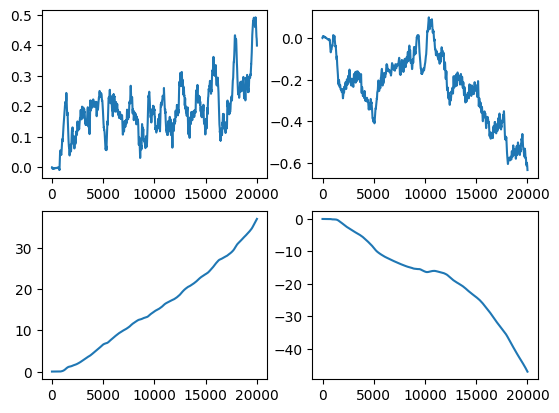

In [ ]:
plt.subplot(2,2,1)
plt.plot(velocity_traj[0])
#plt.plot(targ[:,0])

plt.subplot(2,2,2)
plt.plot(velocity_traj[1])
#plt.plot(targ[:,0])

plt.subplot(2,2,3)
plt.plot(trajectory[0])
#plt.plot(gt_pos[:,0])

plt.subplot(2,2,4)
plt.plot(trajectory[1])
#plt.plot(gt_pos[:,0])

In [ ]:
import argparse
import json
import os
import sys
from os import path as osp

import h5py
import matplotlib.pyplot as plt
import numpy as np
import quaternion
from scipy.interpolate import interp1d

#if want to search for packages from the parent file
#sys.path.append(osp.join(osp.dirname(osp.abspath(__file__)), '..'))

from math_util import *
from metric import compute_absolute_trajectory_error, compute_relative_trajectory_error



All done. Average ate:nan, average rte: nan


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
args = argparse.Namespace()
args.list = None
args.root_dir = None
args.align_length = 600
args.path = None
args.stride = 0.67
args.out_dir = None
args.show_plot = False





In [ ]:
root_dir, data_list = '', []
if args.path is not None:
    if args.path[-1] == '/':
        args.path = args.path[:-1]
    root_dir = osp.split(args.path)[0]
    data_list = [osp.split(args.path)[1]]
elif args.list is not None:
    root_dir = args.root_dir
    with open(args.list) as f:
        data_list = [s.strip().split()[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']

if args.out_dir is not None and not osp.isdir(args.out_dir):
    os.makedirs(args.out_dir)

ate_all, rte_all = [], []
pred_per_min = 200 * 60

for data in data_list:
    data_path = osp.join(root_dir, data)
    with open(osp.join(data_path, 'info.json')) as f:
        info = json.load(f)
        device = info['device']
        rot_imu_to_tango = quaternion.quaternion(*info['start_calibration'])
        ref_time_imu = info['imu_reference_time']
        imu_time_offset = info['imu_time_offset']
        start_frame = info.get('start_frame', 0)

    with h5py.File(osp.join(data_path, 'data.hdf5')) as f:
        ori = np.copy(f['synced/game_rv'])
        tango_ori_q = quaternion.from_float_array(f['pose/tango_ori'])
        ori_q = quaternion.from_float_array(ori)
        init_rotor = tango_ori_q[0] * rot_imu_to_tango * ori_q[0].conj()
        ori = quaternion.as_float_array(init_rotor * ori_q)[start_frame:]

        ts = np.copy(f['synced/time'])[start_frame:]
        tango_pos = np.copy(f['pose/tango_pos'])[start_frame:]
        step = np.copy(f['raw/imu/step'])

    step_ts = step[:, 0] / 1e09 - imu_time_offset
    sid, eid = 0, step_ts.shape[0] - 1
    while sid < step_ts.shape[0] and ts[0] > step_ts[sid]:
        sid += 1
    while eid >= 0 and ts[-1] < step_ts[eid]:
        eid -= 1
    assert sid < step_ts.shape[0] and eid >= 0

    step_ts = step_ts[sid:eid + 1]
    step = step[sid:eid + 1]

    ori_at_step = interpolate_quaternion_linear(ori, ts, step_ts)
    yaw_at_step = orientation_to_angles(ori_at_step)[:, 0]

    rot_hori = np.stack([np.cos(yaw_at_step), np.sin(yaw_at_step),
                         -np.sin(yaw_at_step), np.cos(yaw_at_step)], axis=1).reshape([-1, 2, 2])
    step_v = np.stack([np.zeros(step.shape[0]), np.ones(step.shape[0]) * args.stride], axis=1)

    step_glob = np.squeeze(np.matmul(rot_hori, np.expand_dims(step_v, axis=2)), axis=2)
    pos_pred = np.zeros([step_glob.shape[0] + 1, 2])
    step_ts = np.concatenate([[ts[0]], step_ts], axis=0)
    pos_pred[0] = tango_pos[0][:2]
    pos_pred[1:] = np.cumsum(step_glob, axis=0) + pos_pred[0]

    eid = ts.shape[0] - 1
    while eid >= 0 and ts[eid] > step_ts[-1]:
        eid -= 1
    pos_gt = tango_pos[:eid + 1, :2]
    pos_pred = interp1d(step_ts, pos_pred, axis=0)(ts[:eid + 1])

    if args.align_length is not None and args.align_length > 0:
        _, r, t = icp_fit_transformation(pos_pred[:args.align_length], pos_gt[:args.align_length])
        pos_pred = np.matmul(r, pos_pred.T).T + t

    # For trajectories shorted than 1 min, we scale the RTE value accordingly.
    if pos_pred.shape[0] < pred_per_min:
        ratio = pred_per_min / pos_pred.shape[0]
        rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pos_pred.shape[0] - 1) * ratio
    else:
        rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pred_per_min)
    rte_all.append(rte)

    ate = compute_absolute_trajectory_error(pos_pred, pos_gt)
    ate_all.append(ate)
    print('Sequence {}, ate {:.6f}, rte {:.6f}'.format(data, ate, rte))

    plt.close('all')
    plt.figure(data, figsize=(8, 6))
    plt.plot(pos_gt[:, 0], pos_gt[:, 1])
    plt.plot(pos_pred[:, 0], pos_pred[:, 1])
    plt.legend(['Ground truth', 'Estimated'])
    plt.axis('equal')
    plt.tight_layout()

    if args.out_dir is not None and osp.isdir(args.out_dir):
        plt.savefig(osp.join(args.out_dir, data + '_pdr.png'))

    if args.show_plot:
        plt.show()

print('All done. Average ate:{:.6f}, average rte: {:.6f}'.format(np.mean(ate_all), np.mean(rte_all)))
if args.out_dir is not None and osp.isdir(args.out_dir):
    with open(osp.join(args.out_dir, 'result.csv'), 'w') as f:
        f.write('seq,ate,rte\n')
        for i in range(len(data_list)):
            f.write('{},{:.6f},{:.6f}\n'.format(data_list[i], ate_all[i], rte_all[i]))